In [2]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

# 1. Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# 2. Definisikan Path
base_path = '/content/drive/MyDrive/ChilliGuard/processed'
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')

# Verifikasi folder
if os.path.exists(train_dir):
    print("✅ Folder data ditemukan!")
    print("Daftar Kelas:", os.listdir(train_dir))
else:
    print("❌ Folder tidak ditemukan. Periksa kembali path di Drive kamu.")

Mounted at /content/drive
✅ Folder data ditemukan!
Daftar Kelas: ['chilli_anthracnos', 'chilli_damping_off', 'chilli_healthy_fruit', 'chilli_healthy_leaf', 'chilli_leaf_curl_virus', 'chilli_leaf_spot', 'chilli_veinal_mottle_virus', 'chilli_whitefly', 'chilli_yellowish']


In [3]:
# Target size mengikuti standar MobileNetV2
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Simpan urutan kelas untuk referensi Django nanti
class_indices = train_generator.class_indices
print("\nMapping Kelas untuk Django:", class_indices)

Found 3592 images belonging to 9 classes.
Found 449 images belonging to 9 classes.
Found 449 images belonging to 9 classes.

Mapping Kelas untuk Django: {'chilli_anthracnos': 0, 'chilli_damping_off': 1, 'chilli_healthy_fruit': 2, 'chilli_healthy_leaf': 3, 'chilli_leaf_curl_virus': 4, 'chilli_leaf_spot': 5, 'chilli_veinal_mottle_virus': 6, 'chilli_whitefly': 7, 'chilli_yellowish': 8}


In [4]:
# 1. Base Model menggunakan MobileNetV2 yang sudah terlatih di ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# 2. Freeze base model
base_model.trainable = False

# 3. Tambahkan Classifier Head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3), # Mencegah overfitting
    layers.Dense(256, activation='relu'),
    layers.Dense(9, activation='softmax') # 9 Kelas
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,233 (9.87 MB)

 Trainable params: 330,249 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Callback untuk menyimpan model terbaik
checkpoint_path = '/content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback untuk berhenti otomatis jika tidak ada kemajuan
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Training
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3254 - loss: 1.9460
Epoch 1: val_accuracy improved from -inf to 0.75056, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 1082s 9s/step - accuracy: 0.3267 - loss: 1.9421 - val_accuracy: 0.7506 - val_loss: 0.8042
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7206 - loss: 0.8456
Epoch 2: val_accuracy improved from 0.75056 to 0.82851, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.7208 - loss: 0.8449 - val_accuracy: 0.8285 - val_loss: 0.5451
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8136 - loss: 0.5561
Epoch 3: val_accuracy improved from 0.82851 to 0.86637, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8135 - loss: 0.5561 - val_accuracy: 0.8664 - val_loss: 0.4232
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8391 - loss: 0.4740
Epoch 4: val_accuracy improved from 0.86637 to 0.88641, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.8391 - loss: 0.4739 - val_accuracy: 0.8864 - val_loss: 0.3659
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8702 - loss: 0.4012
Epoch 5: val_accuracy improved from 0.88641 to 0.89532, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.8702 - loss: 0.4011 - val_accuracy: 0.8953 - val_loss: 0.3275
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8929 - loss: 0.3521
Epoch 6: val_accuracy did not improve from 0.89532
113/113 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8928 - loss: 0.3521 - val_accuracy: 0.8909 - val_loss: 0.3195
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8846 - loss: 0.3214
Epoch 7: val_accuracy did not improve from 0.89532
113/113 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8847 - loss: 0.3213 - val_accuracy: 0.8931 - val_loss: 0.2802
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9063 - loss: 0.2856
Epoch 8: val_accuracy improved from 0.89532 to 0.91091, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9063 - loss: 0.2856 - val_accuracy: 0.9109 - val_loss: 0.2556
Epoch 9/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8987 - loss: 0.2867
Epoch 9: val_accuracy did not improve from 0.91091
113/113 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.8987 - loss: 0.2866 - val_accuracy: 0.9087 - val_loss: 0.2623
Epoch 10/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9079 - loss: 0.2634
Epoch 10: val_accuracy improved from 0.91091 to 0.91982, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.9079 - loss: 0.2633 - val_accuracy: 0.9198 - val_loss: 0.2452
Epoch 11/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9238 - loss: 0.2302
Epoch 11: val_accuracy improved from 0.91982 to 0.92205, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.9238 - loss: 0.2302 - val_accuracy: 0.9220 - val_loss: 0.2319
Epoch 12/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9277 - loss: 0.2166
Epoch 12: val_accuracy did not improve from 0.92205
113/113 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9277 - loss: 0.2166 - val_accuracy: 0.9154 - val_loss: 0.2232
Epoch 13/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9370 - loss: 0.1923
Epoch 13: val_accuracy did not improve from 0.92205
113/113 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9370 - loss: 0.1923 - val_accuracy: 0.9220 - val_loss: 0.2266
Epoch 14/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9340 - loss: 0.1929
Epoch 14: val_accuracy improved from 0.92205 to 0.92428, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.9341 - loss: 0.1928 - val_accuracy: 0.9243 - val_loss: 0.2239
Epoch 15/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9449 - loss: 0.1710
Epoch 15: val_accuracy did not improve from 0.92428
113/113 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9449 - loss: 0.1710 - val_accuracy: 0.9220 - val_loss: 0.2026
Epoch 16/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9373 - loss: 0.1694
Epoch 16: val_accuracy improved from 0.92428 to 0.92650, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9373 - loss: 0.1695 - val_accuracy: 0.9265 - val_loss: 0.2043
Epoch 17/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9446 - loss: 0.1624
Epoch 17: val_accuracy improved from 0.92650 to 0.93096, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.9446 - loss: 0.1624 - val_accuracy: 0.9310 - val_loss: 0.1993
Epoch 18/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9479 - loss: 0.1589
Epoch 18: val_accuracy did not improve from 0.93096
113/113 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9479 - loss: 0.1588 - val_accuracy: 0.9265 - val_loss: 0.2031
Epoch 19/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9569 - loss: 0.1378
Epoch 19: val_accuracy did not improve from 0.93096
113/113 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9569 - loss: 0.1379 - val_accuracy: 0.9265 - val_loss: 0.1997
Epoch 20/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9546 - loss: 0.1426
Epoch 20: val_accuracy improved from 0.93096 to 0.93541, saving model to /content/drive/MyDrive/ChilliGuard/chiligard_model_v1.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9547 - loss: 0.1426 - val_accuracy: 0.9354 - val_loss: 0.1979
Epoch 21/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9529 - loss: 0.1414
Epoch 21: val_accuracy did not improve from 0.93541
113/113 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9529 - loss: 0.1414 - val_accuracy: 0.9287 - val_loss: 0.1797
Epoch 22/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9612 - loss: 0.1274
Epoch 22: val_accuracy did not improve from 0.93541
113/113 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9612 - loss: 0.1274 - val_accuracy: 0.9332 - val_loss: 0.1829
Epoch 23/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9569 - loss: 0.1289
Epoch 23: val_accuracy did not improve from 0.93541
113/113 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9569 - loss: 0.1289 - val_accuracy: 0.9243 - val_loss: 0.1960
Epoch 24/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9533 - loss: 0.1268
Epoch 24: val_accuracy did n

15/15 ━━━━━━━━━━━━━━━━━━━━ 121s 8s/step - accuracy: 0.9304 - loss: 0.2060

🎯 Akurasi pada Data Test: 93.99%


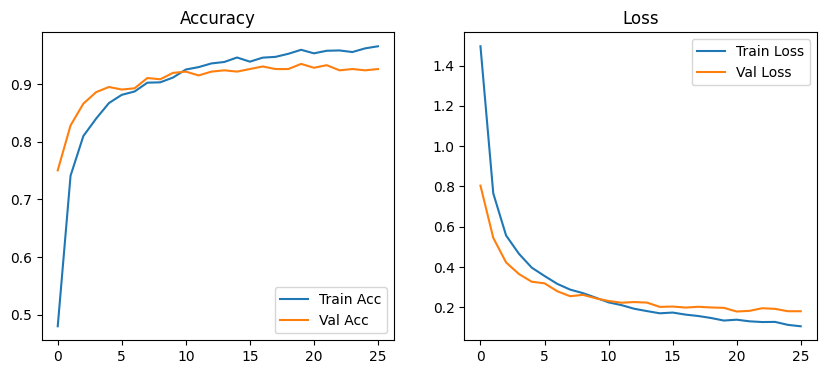

✅ SELESAI! Model 'chiligard_model_v1.h5' dan 'class_labels.txt' siap di Drive kamu.


In [6]:
# 1. Evaluasi pada data Test
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n🎯 Akurasi pada Data Test: {test_acc*100:.2f}%")

# 2. Simpan Mapping Label ke File Teks
with open('/content/drive/MyDrive/ChilliGuard/class_labels.txt', 'w') as f:
    for label, index in class_indices.items():
        f.write(f"{index}:{label}\n")

# 3. Plot Grafik Akurasi
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

print("✅ SELESAI! Model 'chiligard_model_v1.h5' dan 'class_labels.txt' siap di Drive kamu.")